In [1]:
from stat_util import *
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphLassoCV, ledoit_wolf
import codecs, sys
sns.set()


sys.stdout = codecs.getwriter('utf-8')(sys.stdout)
float_formatter = lambda x: "%.6f" % x
np.set_printoptions(threshold=10000,
                    linewidth=100,
                    formatter={'float_kind':float_formatter})



Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
/Users/kennyjoseph/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [8]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from pyspark import SparkContext, SparkConf

conf = (SparkConf()
     .setMaster("local[5]")
     .setAppName("My app")
     .set("spark.driver.maxResultSize", "6g"))
sc = SparkContext(conf=conf)

In [14]:
sc.stop()

In [3]:
import non_user_assoc_mod
non_user_assoc_mod = reload(non_user_assoc_mod)

In [11]:
z = np.load("../r/training_mat.npy")
z = z[(z.sum(axis=1) > 175)]

AttributeError: 'module' object has no attribute 'which'

In [5]:
m = non_user_assoc_mod.AssociationModelNonUser(z, z.shape[1],kappa=200.)

In [12]:
np.save("latest_sim_runs/m_eta",m.eta)
np.save("latest_sim_runs/z",z)

In [13]:
for i in range(m.iteration,100):
    m.iterate(sc)

ASSOC MODEL LL TRAINING, TEST  -12150069.1497 , -12150069.1497
ASSOC MODEL LL TRAINING, TEST  -12104793.0296 , -12104793.0296
ASSOC MODEL LL TRAINING, TEST  -12065378.1935 , -12065378.1935
ASSOC MODEL LL TRAINING, TEST  -12027588.617 , -12027588.617
ASSOC MODEL LL TRAINING, TEST  -11993270.5481 , -11993270.5481
ASSOC MODEL LL TRAINING, TEST  -11960173.2907 , -11960173.2907


KeyboardInterrupt: 

In [40]:
import seaborn as sns
%matplotlib inline
sns.set()

In [50]:
logExpSumWithVector(m.eta[np.abs(m.eta).sum(axis=1).argmax()], m.n_identities)

15.560608388472472

In [10]:
import pypolyagamma as pypolyagamma
ppg = pypolyagamma.PyPolyaGamma(0)
n_identities = z.shape[1]
n_users = z.shape[0]

kappa = 100.
nu = float(n_identities)+1.

mu_0 = np.zeros(n_identities)
W = np.identity(n_identities) * float(kappa)

# init mu, sigma
sigma = sample_invwishart(W,nu)
mu = np.random.multivariate_normal(mu_0, sigma/kappa)

precision_matrix = np.linalg.inv(sigma)
eta = np.zeros((n_users, n_identities))
iteration = -1
train_ll = 0
test_ll = 0


In [12]:

#for itera in range(25):

    for doc_iter in range(n_users):
        if doc_iter % 2000 == 0:
            print doc_iter
        eta_doc = eta[doc_iter,:]
        all_exp_sum = logExpSumWithVector(eta[doc_iter,:], n_identities)
        doc_length = z[doc_iter,:].sum()

        for k in range(n_identities):
            prior_var = 1/precision_matrix[k, k]
            prior_mean = np.dot(precision_matrix[:, k], (eta_doc - mu))
            prior_mean -= precision_matrix[k, k] * (eta_doc[k] - mu[k])
            prior_mean = mu[k] - prior_var*prior_mean

            for temp in range(5):
                all_exp_sum = logExpSubtract(all_exp_sum, eta[doc_iter,:][k])
                zeta = all_exp_sum
                rho = eta[doc_iter,k] - zeta

                # lambda_k:	sample from Polya-Gamma
                lamb = ppg.pgdraw(doc_length, rho)
                kappa = z[doc_iter,k] - doc_length/2.

                # Compute conditional distribution with respect to lambda_k
                tau = 1.0 / ( 1.0 / prior_var + lamb )
                gamma = tau * (prior_mean/prior_var + kappa + lamb*zeta)

                # eta_k: 	sample from normal
                eta[doc_iter,k] = np.random.normal()*sqrt(tau) + gamma
                all_exp_sum = logExpAdd(all_exp_sum, eta[doc_iter,k])

        if eta[doc_iter].sum() > 5000:
            print 'hmpf', doc_iter
            break

#mu, sigma = sample_gaussian(eta, n_identities,n_users, mu_0, W,nu, kappa)
#precision_matrix = np.linalg.inv(sigma)


# compute_perplexity
#print 'PERPL ON TRAINING DATA: ', np.array([log(multinomial(z[i],softmax(eta[i]))) for i in range(n_users)]).sum()


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


KeyboardInterrupt: 

In [20]:
doc_iter=162
eta_doc = eta[doc_iter]
all_exp_sum = logExpSumWithVector(eta[doc_iter,:], n_identities)
doc_length = z[doc_iter,:].sum()

print 'doc len: ', doc_length

for k in range(n_identities):
    print 
    print k
    prior_var = 1/precision_matrix[k, k]
    prior_mean = np.dot(precision_matrix[:, k], (eta_doc - mu))
    prior_mean -= precision_matrix[k, k] * (eta_doc[k] - mu[k])
    prior_mean = mu[k] - prior_var*prior_mean

    print 'pm, pv: ', prior_mean, prior_var
    for temp in range(5):
        all_exp_sum = logExpSubtract(all_exp_sum, eta[doc_iter,:][k])
        zeta = all_exp_sum
        rho = eta[doc_iter,k] - zeta
        
        print 'exp_sum, zet, rho: ' , all_exp_sum, zeta, rho

        # lambda_k:	sample from Polya-Gamma
        lamb = ppg.pgdraw(doc_length, rho)
        kappa = z[doc_iter,k] - doc_length/2.
        
        print 'lamb, kappa', lamb, kappa

        # Compute conditional distribution with respect to lambda_k
        tau = 1.0 / ( 1.0 / prior_var + lamb )
        gamma = tau * (prior_mean/prior_var + kappa + lamb*zeta)
        
        print 'tau, gamma: ', tau, gamma

        # eta_k: 	sample from normal
        eta[doc_iter,k] = np.random.normal()*sqrt(tau) + gamma
        
        print 'res: ', eta[doc_iter,k]
        all_exp_sum = logExpAdd(all_exp_sum, eta[doc_iter,k])
        print 'exp sum: ', all_exp_sum


doc len:  164.0

0
pm, pv:  21.9359073382 0.280316843428
exp_sum, zet, rho:  29.5375026762 29.5375026762 -6.45594935655
lamb, kappa 14.1156812529 -82.0
tau, gamma:  0.0565512566031 23.3667500867
res:  23.2200296733
exp sum:  29.5393055478
exp_sum, zet, rho:  29.5375026762 29.5375026762 -6.31747300293
lamb, kappa 14.2463090409 -82.0
tau, gamma:  0.0561365664925 23.4120001877
res:  23.6152671997
exp sum:  29.5401782977
exp_sum, zet, rho:  29.5375026762 29.5375026762 -5.92223547653
lamb, kappa 15.4547996597 -82.0
tau, gamma:  0.0525701785592 23.8011568377
res:  24.226260709
exp sum:  29.5424263279
exp_sum, zet, rho:  29.5375026762 29.5375026762 -5.31124196724
lamb, kappa 16.8633426275 -82.0
tau, gamma:  0.0489458665844 24.1966340357
res:  24.240989335
exp sum:  29.542499201
exp_sum, zet, rho:  29.5375026762 29.5375026762 -5.29651334124
lamb, kappa 17.6617768073 -82.0
tau, gamma:  0.0471050006691 24.3975054008
res:  24.1792850232
exp sum:  29.5422009144

1
pm, pv:  -8.15455442871 0.3245792

In [15]:
exp(-np.array([log(multinomial(z[i],softmax(eta[i]))) for i in range(n_users)]).sum()/eta.shape[0])

3.0126938380864787e+31

In [10]:
row_to_identity = {int(line.split("\t")[0]) : line.split("\t")[1].strip() for line in open("../data/res_labels.txt")}
identity_to_row = {v:k for k,v in row_to_identity.items()}

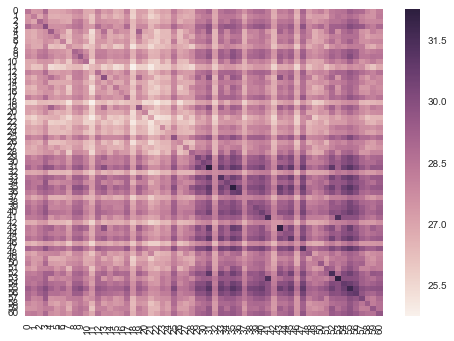

In [11]:
sns.heatmap(sigma)

In [48]:
pd.DataFrame(eta).to_csv("res_csv.csv")

/Users/kennyjoseph/anaconda/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:243: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual gap: 3.232e-04
  ConvergenceWarning)


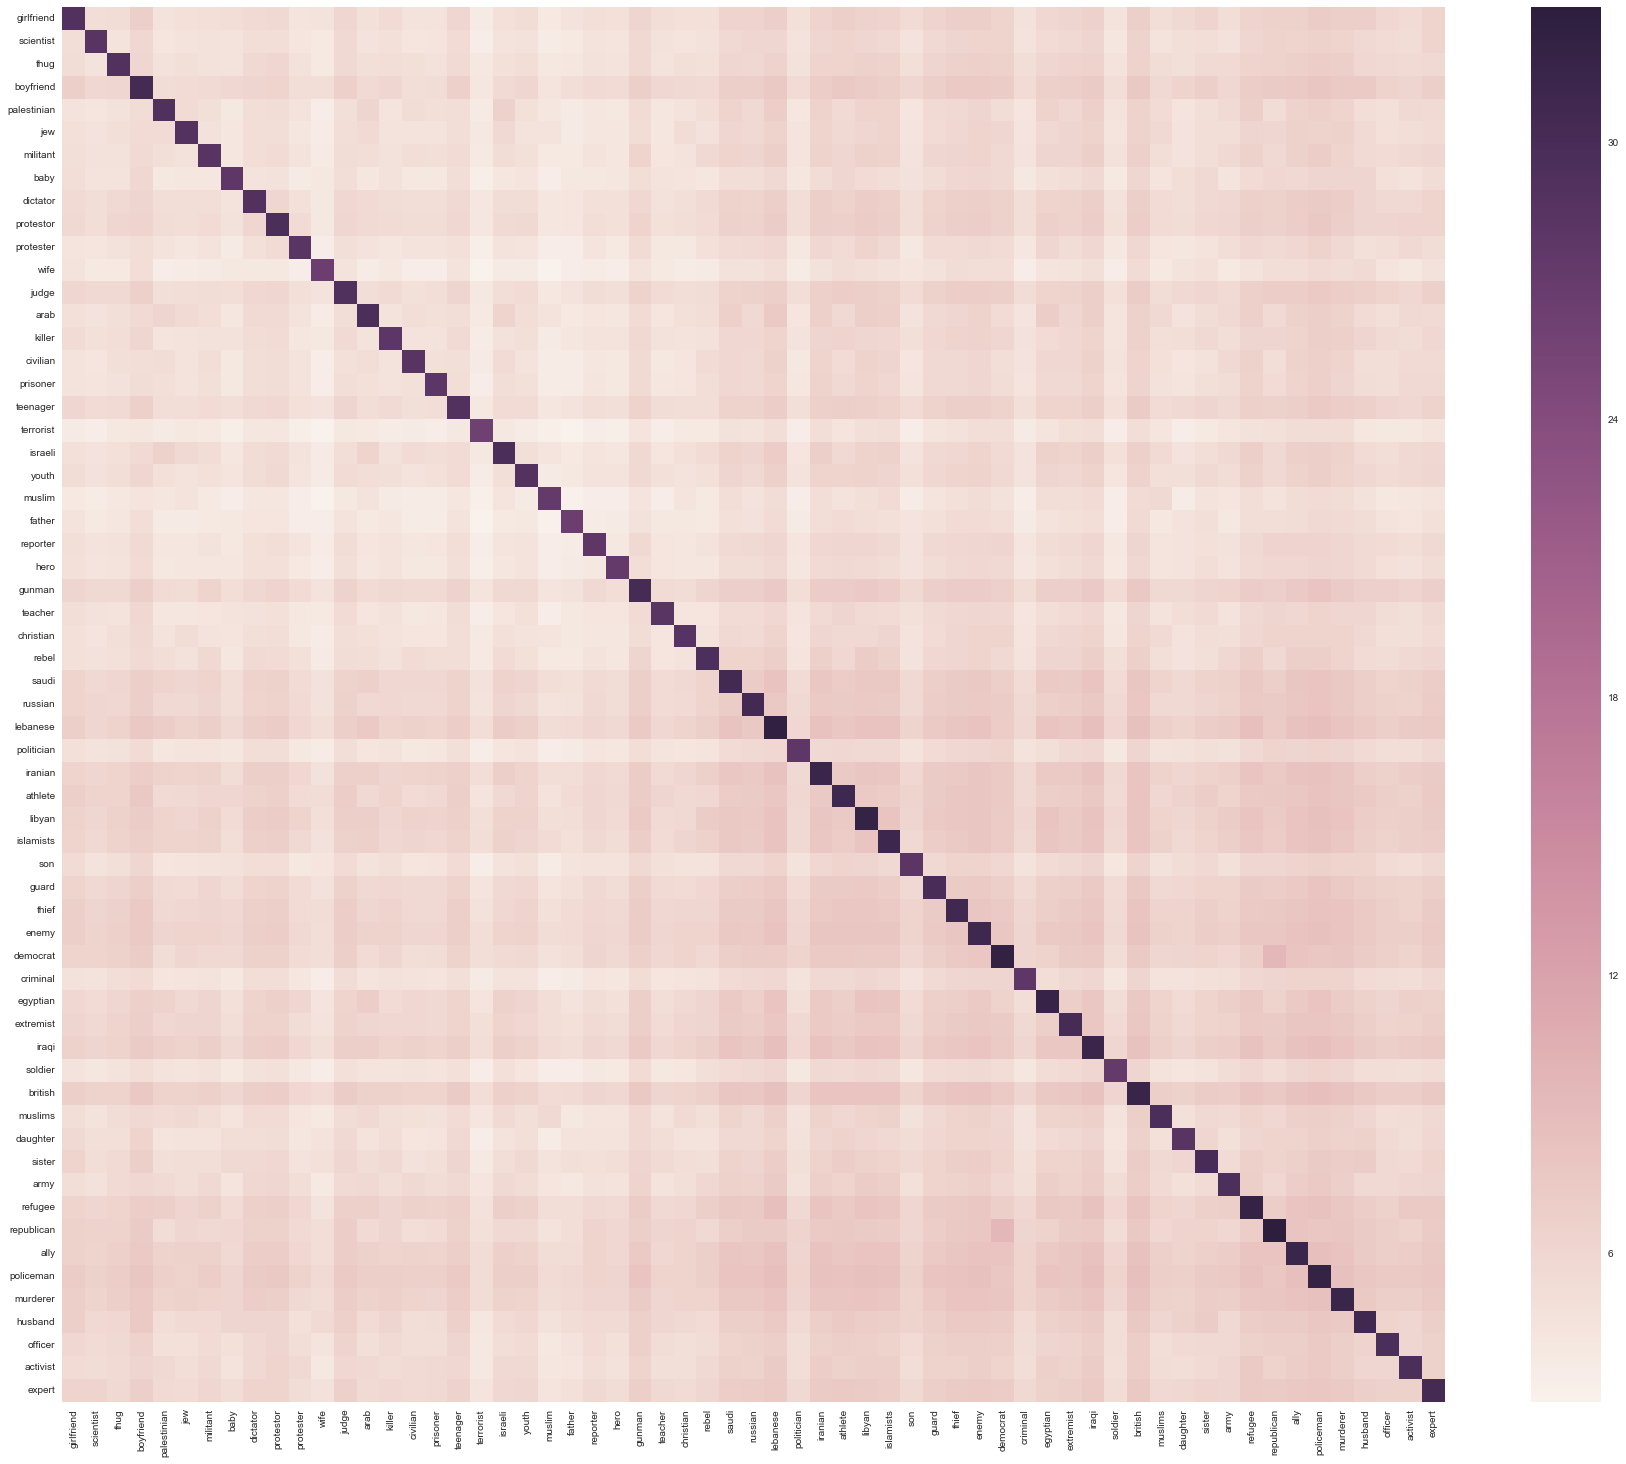

In [12]:
d = eta
model = GraphLassoCV()
model.fit(d)
cov_ = model.covariance_
prec_ = model.precision_

plt.figure(figsize=(25, 25))
plt.subplots_adjust(left=0.02, right=0.98)

labels = [row_to_identity[v] for v in range(n_identities)]

# plot the covariances
sns.heatmap(cov_, xticklabels=labels,yticklabels=labels)

[-0.075990 1.023496 1.966229 3.079953 3.792942 4.940710 5.999471 6.978237 7.957611 8.934253
 -0.038364 0.918130 1.921631 2.982128 4.040236 4.943215 5.902229 7.007359 7.838104 8.989686
 -0.042750 0.914554 1.986013 2.907873 3.940082 5.106141 6.016124 7.081189 7.989959 9.005420 0.001174
 0.979678 1.978881 2.982410 3.916764 5.010948 6.082117 7.047222 7.884287 8.955175 -0.060252 0.895187
 1.931102 2.966031 3.984070 4.935099 5.923698 6.914339 8.051661 8.997978]


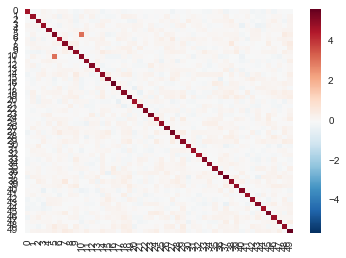

In [90]:
# testing niw stuff
n_id = 50
n_u = 3000
cor_real = np.identity(n_id) * 5
cor_real[5,10] = 3
cor_real[10,5] = 3
eta = np.random.multivariate_normal([i%10 for i in range(n_id)],cor_real, n_u)

mu_0 = np.zeros(n_id)
w = np.identity(n_id) * float(10)
nu = 100.
kappa = 10.

for i in range(100):
    eta_bar = eta.mean(axis=0)
    normed_eta = eta - eta_bar
    q = np.einsum('ij,ik->jk', normed_eta, normed_eta)
    const_1 = n_u/(kappa + n_u)
    exp_mu = mu_0 * (kappa/(kappa + n_u)) + (eta_bar * const_1)
    factor = kappa*const_1
    exp_cov = w + q
    exp_cov += np.outer((eta_bar - mu_0),(eta_bar - mu_0)) * factor

    mu, sigma = sample_niw(exp_mu, exp_cov,nu+n_u, kappa+n_u)
    #eta = np.random.multivariate_normal(mu,sigma, n_u)

sns.heatmap(sigma)
print mu